# INSTALLS AND IMPORTS

In [ ]:
!pip install tensorflow-gpu==2.4.0
!pip install keras==2.4.3
!pip install tensorflow==2.4.0

In [1]:
import datetime
import numpy as np
import scipy.ndimage
import os
import tensorflow as tf
from random import sample
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import *
# import tensorflow_addons as tfa
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, roc_auc_score, auc, recall_score, auc, \
    roc_curve
import time
from skimage.metrics import structural_similarity as ssim


# DATA LOADING

In [2]:
ultrasound_fullname = '/content/drive/MyDrive/Stacked Arrays/Training/stacked_image_array.npy'
segmentation_fullname = '/content/drive/MyDrive/Stacked Arrays/Training/stacked_segmentation_array.npy'

ultrasound_data = np.load(ultrasound_fullname)
segmentation_data = np.load(segmentation_fullname)

print(segmentation_data.shape)
ultrasound_size = ultrasound_data.shape[1:4]

num_ultrasound = ultrasound_data.shape[0]
num_segmentation = segmentation_data.shape[0]

print("\nFound {} ultrasound images and {} segmentations".format(num_ultrasound, num_segmentation))
print("Ultrasound size: {}".format(ultrasound_size))


(67, 128, 128, 128)

Found 67 ultrasound images and 67 segmentations
Ultrasound size: (128, 128, 128)


In [3]:
test_ultrasound_fullname = '/content/drive/MyDrive/Stacked Arrays/Testing/test_image_array.npy'
test_segmentation_fullname = '/content/drive/MyDrive/Stacked Arrays/Testing/test_segmentation_array.npy'

print("Reading test ultrasound from: {}".format(test_ultrasound_fullname))
print("Reading test segmentation from : {}".format(test_segmentation_fullname))

test_ultrasound_data = np.load(test_ultrasound_fullname)
test_segmentation_data = np.load(test_segmentation_fullname)

num_test_ultrasound = test_ultrasound_data.shape[0]
num_test_segmentation = test_segmentation_data.shape[0]

print("\nFound {} test ultrasound images and {} segmentations".format(num_test_ultrasound, num_test_segmentation))

Reading test ultrasound from: /content/drive/MyDrive/Stacked Arrays/Testing/test_image_array.npy
Reading test segmentation from : /content/drive/MyDrive/Stacked Arrays/Testing/test_segmentation_array.npy

Found 15 test ultrasound images and 15 segmentations


In [4]:
val_ultrasound_fullname = '/content/drive/MyDrive/Stacked Arrays/Validation/validation_image_array.npy'
val_segmentation_fullname = '/content/drive/MyDrive/Stacked Arrays/Validation/validation_segmentation_array.npy'

print("Reading test ultrasound from: {}".format(val_ultrasound_fullname))
print("Reading test segmentation from : {}".format(val_segmentation_fullname))

val_ultrasound_data = np.load(val_ultrasound_fullname)
val_segmentation_data = np.load(val_segmentation_fullname)

num_val_ultrasound = val_ultrasound_data.shape[0]
num_val_segmentation = val_segmentation_data.shape[0]

print("\nFound {} test ultrasound images and {} segmentations".format(num_val_ultrasound, num_val_segmentation))

Reading test ultrasound from: /content/drive/MyDrive/Stacked Arrays/Validation/validation_image_array.npy
Reading test segmentation from : /content/drive/MyDrive/Stacked Arrays/Validation/validation_segmentation_array.npy

Found 15 test ultrasound images and 15 segmentations


In [5]:
ultrasound_data = np.reshape(ultrasound_data, (ultrasound_data.shape[0], 128, 128, 128, 1))
segmentation_data = np.reshape(segmentation_data, (segmentation_data.shape[0], 128, 128, 128, 1))

test_ultrasound_data = np.reshape(test_ultrasound_data, (test_ultrasound_data.shape[0], 128, 128, 128, 1))
test_segmentation_data = np.reshape(test_segmentation_data, (test_segmentation_data.shape[0], 128, 128, 128, 1))

val_ultrasound_data = np.reshape(val_ultrasound_data, (val_ultrasound_data.shape[0], 128, 128, 128, 1))
val_segmentation_data = np.reshape(val_segmentation_data, (val_segmentation_data.shape[0], 128, 128, 128, 1))

In [6]:
batch_size = 5
num_epochs = 200

max_rotation_angle = 2.5
max_shift = 0.1
max_zoom = 0.1

# FUNCTIONS

In [7]:
# Multi-slice view code extracted and adapted from:
# https://www.datacamp.com/community/tutorials/matplotlib-3d-volumetric-data

import matplotlib.pyplot as plt

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

In [8]:
# Batch Generator

class UltrasoundSegmentationBatchGenerator(keras.utils.Sequence):
    
    def __init__(self,
                 x_set,
                 y_set,
                 batch_size,
                 image_dimensions,
                 shuffle=True,
                 n_channels=1,
                 n_classes=2):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dimensions = image_dimensions
        print("Generator created for image size: {}".format(self.image_dimensions))
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.number_of_images = self.x.shape[0]
        self.indices = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indices)
            
    def __len__(self):
        return int(np.floor(self.number_of_images / self.batch_size))
    
    def on_epoch_end(self):
        self.indices = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indices)
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dimensions, self.n_channels))
        y = np.empty((self.batch_size, *self.image_dimensions))
        
        for i in range(self.batch_size):
            flip_flag = np.random.randint(2)
            if flip_flag == 1:
                x[i,:,:,:,:] = np.flip(self.x[batch_indices[i],:,:,:,:], axis=0)
                y[i,:,:,:]   = np.flip(self.y[batch_indices[i],:,:,:,0], axis=0)
            else:
                x[i,:,:,:,:] = self.x[batch_indices[i],:,:,:,:]
                y[i,:,:,:]   = self.y[batch_indices[i],:,:,:,0]
            
        # Rotations
        
        x_rot = np.copy(x)
        y_rot = np.copy(y)
        
            
        for i in range(self.batch_size):
            angle_x = np.random.randint(-max_rotation_angle, max_rotation_angle)
            x_rot[i,:,:,:,:] = scipy.ndimage.interpolation.rotate(
                x[i,:,:,:,:], angle_x, (1,2), False, mode="constant", cval=0, order=0)
            y_rot[i,:,:,:] = scipy.ndimage.interpolation.rotate(
                y[i,:,:,:], angle_x, (1,2), False, mode="constant", cval=0, order=0)
            
            #angle_y = np.random.randint(-max_rotation_angle, max_rotation_angle)
            #x_rot[i,:,:,:,:] = scipy.ndimage.interpolation.rotate(
                #x_rot[i,:,:,:,:], angle_x, (0,2), False, mode="constant", cval=0, order=0)
            #y_rot[i,:,:,:] = scipy.ndimage.interpolation.rotate(
                #y[i,:,:,:], angle_x, (0,2), False, mode="constant", cval=0, order=0)
        
        
        # angle_z = np.random.randint(-max_rotation_angle, max_rotation_angle)
        # x_rot = scipy.ndimage.interpolation.rotate(x, angle_z, (0,1), False, mode="constant", cval=0, order=0)
        # y_rot = scipy.ndimage.interpolation.rotate(y, angle_z, (0,1), False, mode="constant", cval=0, order=0)
        
        # shift
        
        shift = np.random.uniform(-max_shift, max_shift, size=5)
        shift[0] = 0.0
        shift[4] = 0.0
        # x_shift = scipy.ndimage.interpolation.shift(x_rot, shift)
        # y_shift = scipy.ndimage.interpolation.shift(y_rot, shift[:4])
        
        # make sure values are between 0 and 1
        
        # x_aug = np.clip(x_shift, 0.0, 1.0)
        # y_aug = np.clip(y_shift, 0.0, 1.0)
        
        x_aug = np.clip(x_rot, 0.0, 1.0)
        y_aug = np.clip(y_rot, 0.0, 1.0)
        # y_aug = y_aug.reshape((y_aug.shape[0], y_aug.shape[1], y_aug.shape[2], y_aug.shape[3], 1))
        # convert segmentation to one-hot encoding
        
        y_onehot = keras.utils.to_categorical(y_aug, self.n_classes)
        return x_aug, y_onehot

In [9]:
# Test input generator

# training_generator = UltrasoundSegmentationBatchGenerator(
#     ultrasound_data,
#     segmentation_data,
#     batch_size,
#     image_dimensions=(ultrasound_size))

# bx, by = training_generator.__getitem__(0)

# print("x shape: {} --- min: {} --- max: {}".format(bx.shape, bx.min(), bx.max()))
# print("y shape: {} --- min: {} --- max: {}".format(by.shape, by.min(), by.max()))

In [10]:
def dilateStack(segmentation_data, iterations):
    return np.array([scipy.ndimage.binary_dilation(y, iterations=iterations) for y in segmentation_data])

width = 3
segmentation_dilated = dilateStack(segmentation_data[:, :, :, :, :], width)

In [11]:
num_classes = 2
filter_multiplier = 6

def nvidia_unet(input_size=128, num_classes=num_classes, activation='softmax'):
    input_ = Input((input_size, input_size, input_size, 1))
    skips = []
    output = input_
    c = num_classes
    
    num_layers = int(np.floor(np.log2(input_size)))
    down_conv_kernel_sizes = np.zeros([num_layers], dtype=int)
    down_filter_numbers = np.zeros([num_layers], dtype=int)
    up_conv_kernel_sizes = np.zeros([num_layers], dtype=int)
    up_filter_numbers = np.zeros([num_layers], dtype=int)
    
    for layer_index in range(num_layers):
        down_conv_kernel_sizes[layer_index] = int(3)
        down_filter_numbers[layer_index] = int( (layer_index + 1) * filter_multiplier + num_classes )
        up_conv_kernel_sizes[layer_index] = int(4)
        up_filter_numbers[layer_index] = int( (num_layers - layer_index - 1) * filter_multiplier + num_classes )
    
    print("Number of layers:       {}".format(num_layers))
    print("Filters in layers down: {}".format(down_filter_numbers))
    print("Filters in layers up:   {}".format(up_filter_numbers))
    
    for shape, filters in zip(down_conv_kernel_sizes, down_filter_numbers):
        skips.append(output)
        output= Conv3D(filters, (shape, shape, shape), strides=2, padding="same", activation="relu")(output)
        
    for shape, filters in zip(up_conv_kernel_sizes, up_filter_numbers):
        output = keras.layers.UpSampling3D()(output)
        skip_output = skips.pop()
        output = concatenate([output, skip_output], axis=4)

        if filters != num_classes:
            output = Conv3D(filters, (shape, shape, shape), activation="relu", padding="same")(output)
            output = BatchNormalization(momentum=.9)(output)
        else:
            output = Conv3D(filters, (shape, shape, shape), activation=activation, padding="same")(output)
    
    assert len(skips) == 0
    return Model([input_], [output])

# model.summary()

In [12]:

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coeff(y_true, y_pred, smooth=1e-6, gama=2):
  y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
  nominator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_true)) + smooth
  denominator = tf.reduce_sum(y_pred ** gama) + tf.reduce_sum(y_true ** gama) + smooth
  result = tf.divide(nominator, denominator)
  return result

def f1_score_metric(y_true, y_pred):
  recall = tf.keras.metrics.Recall()
  precision = tf.keras.metrics.Precision()
  recall.update_state(y_true, y_pred)
  recall_res = recall.result()
  precision.update_state(y_true, y_pred)
  precision_res = precision.result()
  return 2 * precision_res * recall_res / (precision_res + recall_res)

def f1_metric(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

In [13]:
from keras import backend as K

def customLoss(yTrue,yPred):
  return K.sum(K.log(yTrue) - K.log(yPred))

def dice_loss(y_true, y_pred):
  return 1.0-dice_coeff(y_true, y_pred)

def iou_loss(y_true, y_pred):
  m = tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(y_true, y_pred)
  return -tf.math.log(m.result())

def weighted_categorical_crossentropy(weights):
  """
  A weighted version of keras.objectives.categorical_crossentropy

  Variables:
      weights: numpy array of shape (C,) where C is the number of classes
  """
  weights = K.variable(weights)

  def loss(y_true, y_pred):
      # scale predictions so that the class probas of each sample sum to 1
      y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
      # clip to prevent NaN's and Inf's
      y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
      # calc
      loss = y_true * K.log(y_pred) * weights
      loss = -K.sum(loss, -1)

      return loss

  return loss

def weighted_categorical_crossentropy_helper(y_true, y_pred, weights):
# scale predictions so that the class probas of each sample sum to 1
  y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
  # clip to prevent NaN's and Inf's
  y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
  # calc
  loss = y_true * K.log(y_pred) * weights
  loss = -K.sum(loss, -1)
  return loss

def FocalLoss(targets, inputs, alpha=0.9, gamma=2):    
  targets = K.cast(targets, 'float32')
  BCE = K.binary_crossentropy(targets, inputs)
  BCE_EXP = K.exp(-BCE)
  focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
  return focal_loss

def weighted_bce_dice_loss(y_true, y_pred):
  wcce = weighted_categorical_crossentropy_helper(y_true, y_pred, [0.0068, 1.0000])
  dice = dice_loss(y_true, y_pred)
  loss =  wcce + dice
  return loss

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
  y_true_pos = K.flatten(y_true)
  y_pred_pos = K.flatten(y_pred)
  true_pos = K.sum(y_true_pos * y_pred_pos)
  false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
  false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
  return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
  return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
  tv = tversky(y_true, y_pred)
  return K.pow((1 - tv), gamma)

def wcce_focal(y_true, y_pred):
  wcce = weighted_categorical_crossentropy_helper(y_true, y_pred, [0.0068, 1.0000])
  focal = FocalLoss(y_true, y_pred)
  loss = wcce + focal
  return loss

def focal_dice(y_true, y_pred):
  focal = FocalLoss(y_true, y_pred)
  dice = dice_loss(y_true, y_pred)
  return focal + dice

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def visualize_model(model, training_log):
  plt.figure(1)

  plt.subplot(211)
  plt.plot(training_log.history['loss'], 'bo--')
  plt.plot(training_log.history['val_loss'], 'ro-')
  plt.ylabel('Loss')
  plt.xlabel('Epochs (n)')
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  plt.subplot(212)
  plt.plot(training_log.history['accuracy'], 'bo--')
  plt.plot(training_log.history['val_accuracy'], 'ro-')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs (n)')
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

  # ultrasound
  ultrasound_img = test_ultrasound_data[5]
  print(test_ultrasound_data[5].shape)
  multi_slice_viewer(ultrasound_img[:, :, :, 0])

  # Segmentation
  segmentation_img = test_segmentation_data[5]
  print(segmentation_img.shape)
  multi_slice_viewer(segmentation_img[:, :, :, 0])

  y_pred = model.predict(test_ultrasound_data)
  print(np.unique(y_pred))
  # Prediction
  predicted_img = y_pred[5]
  print(predicted_img.shape)
  print(np.unique(predicted_img))
  multi_slice_viewer(predicted_img[:, :, :, 1])

  # Prediction binary
  predicted_img_bin = y_pred[5]
  predicted_img_bin[predicted_img_bin >= 0.5] = 1
  predicted_img_bin[predicted_img_bin < 0.5] = 0
  print(predicted_img_bin.shape)
  print(np.unique(predicted_img_bin))
  multi_slice_viewer(predicted_img_bin[:, :, :, 1])



In [88]:
from scipy import stats
from skimage.filters import threshold_otsu
from skimage.filters import try_all_threshold

def evaluate_model(y_pred, slice_ex=5, threshold=0.5):
  y_true = test_segmentation_data
  # y_pred = model.predict(test_ultrasound_data)
  y_true = y_true[:,:,:,:,0]
  y_pred = y_pred[:,:,:,:,1]

  thresh = threshold_otsu(y_pred)
  print(thresh)
  y_pred[y_pred < thresh] = 0
  y_pred[y_pred >= thresh] = 1
  
  print(y_true.shape)
  print(y_pred.shape)
  # True positive
  tp = np.sum(y_true * y_pred)
  # False positive
  fp = np.sum((y_true == 0) * y_pred)
  # True negative
  tn = np.sum((y_true==0) * (y_pred==0))
  # False negative
  fn = np.sum(y_true * (y_pred==0))

  # True positive rate (sensitivity or recall)
  tpr = tp / (tp + fn)
  # False positive rate (fall-out)
  fpr = fp / (fp + tn)
  # Precision
  precision = tp / (tp + fp)
  # True negatvie tate (specificity)
  tnr = 1 - fpr
  # F1 score
  f1 = 2*tp / (2*tp + fp + fn)
  # F2 score
  f2 = 5*tp / (4*fp + fn)

  # ROC-AUC for binary classification
  auc = (tpr+tnr) / 2
  # MCC
  mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
  ppv = tp/ (tp + fp)
  print("True positive: ", tp)
  print("False positive: ", fp)
  print("True negative: ", tn)
  print("False negative: ", fn)

  print("True positive rate (recall): ", tpr)
  print("False positive rate: ", fpr)
  print("Positive predictive value", ppv)
  print("Precision: ", precision)
  print("True negative rate: ", tnr)
  print("F1: ", f1)
  print("F2: ", f2)
  print("ROC-AUC: ", auc)
  print("MCC: ", mcc)

  segmentation_img = test_segmentation_data[slice_ex,:,:,:,0]

  max_cath = 0
  slice_num =0
  for i in range(128):
    curr_slice = segmentation_img[slice_num, :, :]
    count = np.count_nonzero(segmentation_img[i, :, :])
    if count > max_cath:
      max_cath = count
      slice_num = i
  
  print(segmentation_img.shape)
  print(np.unique(segmentation_img))
  plt.imshow(segmentation_img[slice_num, :, :], cmap="gray")
  plt.show()

  # Prediction
  predicted_img = y_pred[slice_ex]
  print(predicted_img.shape)
  print(np.unique(predicted_img))
  plt.imshow(predicted_img[slice_num, :, :], cmap="gray")
  plt.show()

In [16]:
training_generator = UltrasoundSegmentationBatchGenerator(
    ultrasound_data,
    segmentation_data,
    batch_size,
    image_dimensions=(ultrasound_size))
val_generator = UltrasoundSegmentationBatchGenerator(
    val_ultrasound_data,
    val_segmentation_data,
    batch_size,
    image_dimensions=(ultrasound_size))
test_generator = UltrasoundSegmentationBatchGenerator(
    test_ultrasound_data,
    test_segmentation_data,
    1,
    image_dimensions=(ultrasound_size))

Generator created for image size: (128, 128, 128)
Generator created for image size: (128, 128, 128)
Generator created for image size: (128, 128, 128)


# DICE LOSS MODEL

In [20]:
max_learning_rate = 0.01
min_learning_rate = 0.00001

model_dice_loss = nvidia_unet(ultrasound_size[0], num_classes)
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
filename='/content/drive/MyDrive/3DUnetSavedModels/model_dice_loss.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

model_dice_loss.compile(optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss=dice_loss, metrics=["accuracy", 
                                        dice_coeff, 
                                        tf.keras.metrics.Precision(), 
                                        tf.keras.metrics.Recall(), 
                                        iou_coef])

print("Learning rate decay = {}".format(learning_rate_decay))


Number of layers:       7
Filters in layers down: [ 8 14 20 26 32 38 44]
Filters in layers up:   [38 32 26 20 14  8  2]
Learning rate decay = 4.995e-05


In [21]:
training_time_start = datetime.datetime.now()

training_log_dice = model_dice_loss.fit_generator(training_generator,
                                   validation_data=val_generator,
                                   epochs=num_epochs,
                                   verbose=1, callbacks=[callback, history_logger])

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

saved_models_folder = '/content/drive/MyDrive/3DUnetSavedModels'
model_file_name = "model_dice_loss_" + timestamp + ".h5"
weights_file_path = os.path.join(saved_models_folder, model_file_name)

model_dice_loss.save(weights_file_path)
print("Unet Model saved to: {}".format(weights_file_path))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
13/13 [==============================] - 29s 2s/step - loss: 0.2460 - accuracy: 0.7261 - dice_coeff: 0.7540 - precision_1: 0.7261 - recall_1: 0.7261 - iou_coef: 0.3591 - val_loss: 0.3874 - val_accuracy: 0.6116 - val_dice_coeff: 0.6126 - val_precision_1: 0.6116 - val_recall_1: 0.6116 - val_iou_coef: 0.3075
Epoch 2/200
13/13 [==============================] - 24s 2s/step - loss: 0.0082 - accuracy: 0.9931 - dice_coeff: 0.9918 - precision_1: 0.9931 - recall_1: 0.9931 - iou_coef: 0.4885 - val_loss: 0.0085 - val_accuracy: 0.9916 - val_dice_coeff: 0.9915 - val_precision_1: 0.9916 - val_recall_1: 0.9916 - val_iou_coef: 0.4951
Epoch 3/200
13/13 [==============================] - 25s 2s/step - loss: 0.0064 - accuracy: 0.9936 - dice_coeff: 0.9936 - precision_1: 0.9936 - recall_1: 0.9936 - iou_coef: 0.4961 - val_loss: 0.0084 - val_accuracy: 0.9916 - val_dice_coeff: 0.9916 - val_precision_1: 0.9916 - val_recall_1: 0.9916 - val_iou_coef: 0.4954
Epoch 4/200
13/13 [========================

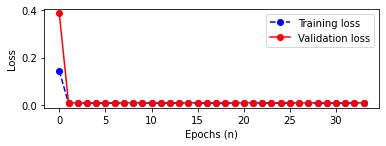

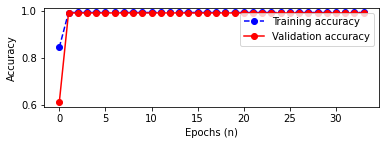

(128, 128, 128, 1)
(128, 128, 128, 1)
[9.4508026e-11 1.3185188e-10 1.5168390e-10 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(128, 128, 128, 2)
[2.7574484e-10 3.8071332e-10 4.2158735e-10 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(128, 128, 128, 2)
[0. 1.]


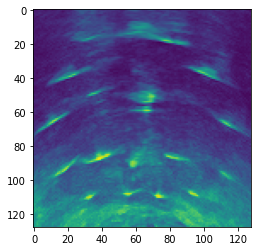

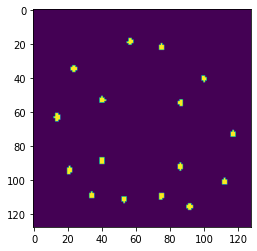

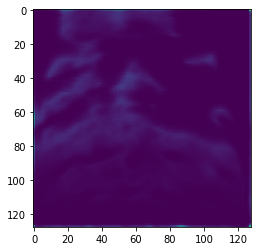

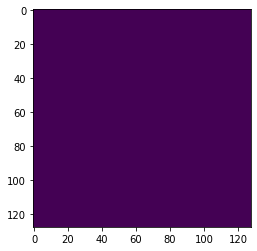

In [22]:
visualize_model(model_dice_loss, training_log_dice)

0.01746706
(15, 128, 128, 128)
(15, 128, 128, 128)
True positive:  0.0
False positive:  230.41455
True negative:  31247948
False negative:  202615.0
True positive rate (recall):  0.0
False positive rate:  7.373695443122437e-06
Positive predictive value 0.0
Precision:  0.0
True negative rate:  0.9999926263045569
F1:  0.0
F2:  0.0
ROC-AUC:  0.49999631315227844
MCC:  -0.00021795366827033691
64
(128, 128, 128)
[0. 1.]


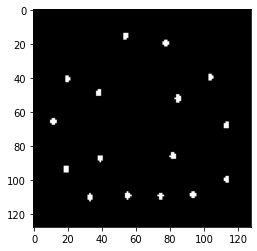

(128, 128, 128)
[0.         0.01747466 0.01750543 0.01755092 0.01755517 0.01757164
 0.01759147 0.01760039 0.01760287 0.01760935 0.01763223 0.01763811
 0.01767491 0.01768391 0.01769468 0.01770867 0.01773797 0.01775197
 0.01775492 0.0177649  0.01778917 0.01779761 0.01779798 0.01782787
 0.01783776 0.01784136 0.0178415  0.01785015 0.01785317 0.01787417
 0.0178893  0.01789403 0.01790065 0.01790573 0.01790734 0.01790951
 0.01791422 0.01791895 0.01792458 0.01792766 0.01792772 0.01793029
 0.01793741 0.01793975 0.01794069 0.01794564 0.01794961 0.01794974
 0.0179519  0.01795383 0.01796434 0.01796975 0.01796982 0.01797164
 0.01797287 0.01797601 0.01797677 0.01797756 0.01797781 0.0179818
 0.01799486 0.01802241 0.01805567 0.01809423 0.01813451 0.01814227
 0.0181571  0.0182172  0.01821973 0.01822057 0.01835846 0.01835871
 0.01842303 0.01845928 0.01852199 0.01855668 0.01857577 0.01860206
 0.01865766 0.01866439 0.01868771 0.01869804 0.01872399 0.01872634
 0.01874217 0.01875677 0.01876681 0.0188163  0.

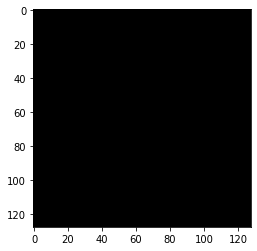

In [23]:
y_pred = model_dice_loss.predict(test_ultrasound_data)
evaluate_model(y_pred)

# TVERSKY FOCAL LOSS

In [24]:
max_learning_rate = 0.01
min_learning_rate = 0.00001

model_tversky_focal = nvidia_unet(ultrasound_size[0], num_classes)
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
filename='/content/drive/MyDrive/3DUnetSavedModels/model_tversky_focal.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)
model_tversky_focal.compile(optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss=focal_tversky_loss, metrics=["accuracy", 
                                                dice_coeff, 
                                                tf.keras.metrics.Precision(), 
                                                tf.keras.metrics.Recall(), 
                                                iou_coef])

print("Learning rate decay = {}".format(learning_rate_decay))



Number of layers:       7
Filters in layers down: [ 8 14 20 26 32 38 44]
Filters in layers up:   [38 32 26 20 14  8  2]
Learning rate decay = 4.995e-05


In [25]:
training_time_start = datetime.datetime.now()

training_log_tversky_focal = model_tversky_focal.fit_generator(training_generator,
                                   validation_data=val_generator,
                                   epochs=num_epochs,
                                   verbose=1, callbacks=[callback,history_logger])

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

saved_models_folder = '/content/drive/MyDrive/3DUnetSavedModels'
model_file_name = "model_tversky_focal_" + timestamp + ".h5"
weights_file_path = os.path.join(saved_models_folder, model_file_name)

model_tversky_focal.save(weights_file_path)
print("Unet Model saved to: {}".format(weights_file_path))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
13/13 [==============================] - 29s 2s/step - loss: 0.3460 - accuracy: 0.7405 - dice_coeff: 0.7803 - precision_2: 0.7405 - recall_2: 0.7405 - iou_coef: 0.3721 - val_loss: 0.6617 - val_accuracy: 0.4268 - val_dice_coeff: 0.4282 - val_precision_2: 0.4268 - val_recall_2: 0.4268 - val_iou_coef: 0.2145
Epoch 2/200
13/13 [==============================] - 24s 2s/step - loss: 0.0399 - accuracy: 0.9874 - dice_coeff: 0.9874 - precision_2: 0.9874 - recall_2: 0.9874 - iou_coef: 0.4932 - val_loss: 0.4097 - val_accuracy: 0.6963 - val_dice_coeff: 0.7138 - val_precision_2: 0.6963 - val_recall_2: 0.6963 - val_iou_coef: 0.3504
Epoch 3/200
13/13 [==============================] - 24s 2s/step - loss: 0.0231 - accuracy: 0.9934 - dice_coeff: 0.9934 - precision_2: 0.9934 - recall_2: 0.9934 - iou_coef: 0.4967 - val_loss: 0.0280 - val_accuracy: 0.9915 - val_dice_coeff: 0.9915 - val_precision_2: 0.9915 - val_recall_2: 0.9915 - val_iou_coef: 0.4958
Epoch 4/200
13/13 [========================

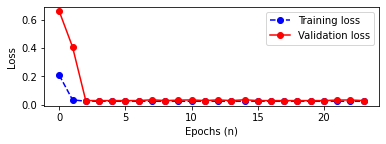

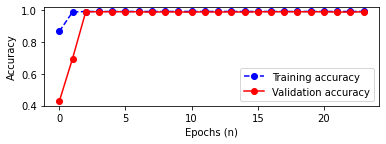

(128, 128, 128, 1)
(128, 128, 128, 1)
[0.0000000e+00 1.1755894e-38 1.1757239e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(128, 128, 128, 2)
[0.0000000e+00 1.1757239e-38 1.1808480e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(128, 128, 128, 2)
[0. 1.]


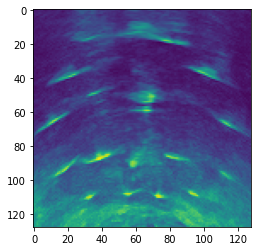

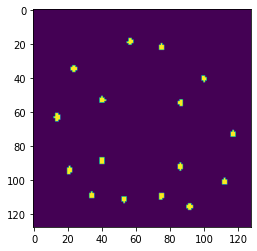

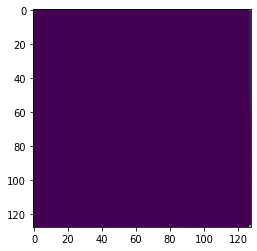

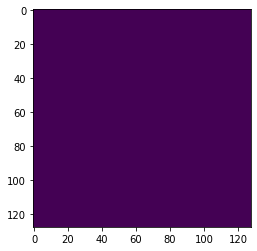

In [26]:
visualize_model(model_tversky_focal, training_log_tversky_focal)

0.0010026785
(15, 128, 128, 128)
(15, 128, 128, 128)
True positive:  0.0
False positive:  4867.0
True negative:  31249798
False negative:  202615.0
True positive rate (recall):  0.0
False positive rate:  0.000155720754005842
Positive predictive value 0.0
Precision:  0.0
True negative rate:  0.9998442792459942
F1:  0.0
F2:  0.0
ROC-AUC:  0.4999221396229971
MCC:  -0.001001571737503083
64
(128, 128, 128)
[0. 1.]


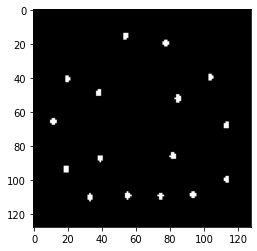

(128, 128, 128)
[0. 1.]


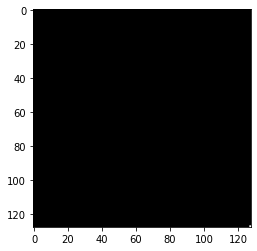

In [35]:
y_pred = model_tversky_focal.predict(test_ultrasound_data)
evaluate_model(y_pred)

# FOCAL LOSS

In [28]:
max_learning_rate = 0.01
min_learning_rate = 0.00001

model_focal_loss = nvidia_unet(ultrasound_size[0], num_classes)
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs
# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
filename='/content/drive/MyDrive/3DUnetSavedModels/model_focal_loss.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)
model_focal_loss.compile(optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss=FocalLoss, metrics=["accuracy", 
                                        dice_coeff, 
                                        tf.keras.metrics.Precision(),
                                        tf.keras.metrics.Recall(), 
                                        iou_coef])
print("Learning rate decay = {}".format(learning_rate_decay))



Number of layers:       7
Filters in layers down: [ 8 14 20 26 32 38 44]
Filters in layers up:   [38 32 26 20 14  8  2]
Learning rate decay = 4.995e-05


In [29]:
training_time_start = datetime.datetime.now()
training_log_focal_loss = model_focal_loss.fit_generator(training_generator,
                                   validation_data=val_generator,
                                   epochs=num_epochs,
                                   verbose=1, callbacks=[callback,history_logger])

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

saved_models_folder = '/content/drive/MyDrive/3DUnetSavedModels'
model_file_name = "model_focal_loss_" + timestamp + ".h5"
weights_file_path = os.path.join(saved_models_folder, model_file_name)

model_focal_loss.save(weights_file_path)
print("Unet Model saved to: {}".format(weights_file_path))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
13/13 [==============================] - 29s 2s/step - loss: 0.2122 - accuracy: 0.7601 - dice_coeff: 0.7977 - precision_3: 0.7601 - recall_3: 0.7601 - iou_coef: 0.3437 - val_loss: 0.1945 - val_accuracy: 0.9895 - val_dice_coeff: 0.9849 - val_precision_3: 0.9895 - val_recall_3: 0.9895 - val_iou_coef: 0.4789
Epoch 2/200
13/13 [==============================] - 23s 2s/step - loss: 0.0212 - accuracy: 0.9936 - dice_coeff: 0.9925 - precision_3: 0.9936 - recall_3: 0.9936 - iou_coef: 0.4892 - val_loss: 0.0279 - val_accuracy: 0.9915 - val_dice_coeff: 0.9897 - val_precision_3: 0.9915 - val_recall_3: 0.9915 - val_iou_coef: 0.4844
Epoch 3/200
13/13 [==============================] - 23s 2s/step - loss: 0.0206 - accuracy: 0.9935 - dice_coeff: 0.9930 - precision_3: 0.9935 - recall_3: 0.9935 - iou_coef: 0.4931 - val_loss: 0.0221 - val_accuracy: 0.9915 - val_dice_coeff: 0.9902 - val_precision_3: 0.9915 - val_recall_3: 0.9915 - val_iou_coef: 0.4879
Epoch 4/200
13/13 [========================

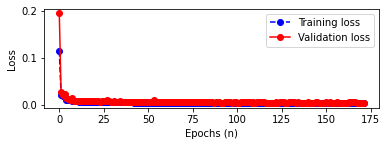

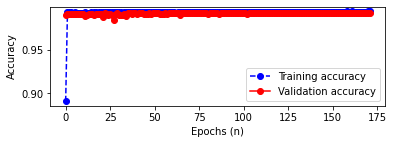

(128, 128, 128, 1)
(128, 128, 128, 1)
[0.0000000e+00 1.1758136e-38 1.1769534e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(128, 128, 128, 2)
[0.0000000e+00 1.2310017e-38 1.2393889e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(128, 128, 128, 2)
[0. 1.]


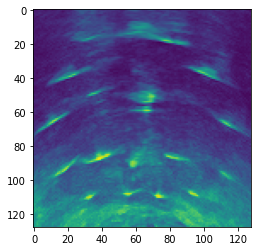

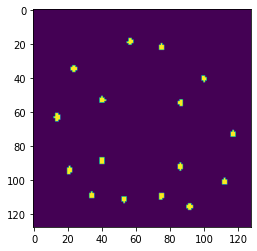

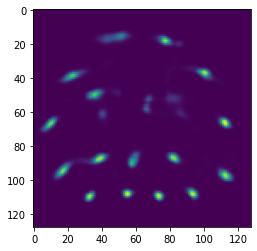

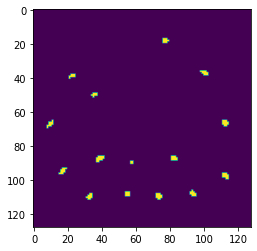

In [30]:
visualize_model(model_focal_loss, training_log_focal_loss)

0.19203281
(15, 128, 128, 128)
(15, 128, 128, 128)
True positive:  147783.0
False positive:  440810.0
True negative:  30813855
False negative:  54832.0
True positive rate (recall):  0.7293783777114231
False positive rate:  0.014103814582559115
Positive predictive value 0.2510784192132764
Precision:  0.2510784192132764
True negative rate:  0.9858961854174408
F1:  0.3735629568962902
F2:  0.40642779823901365
ROC-AUC:  0.857637281564432
MCC:  0.4222788954426316
64
(128, 128, 128)
[0. 1.]


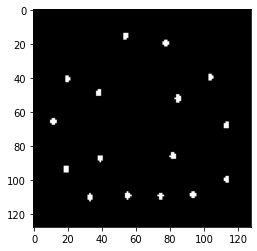

(128, 128, 128)
[0. 1.]


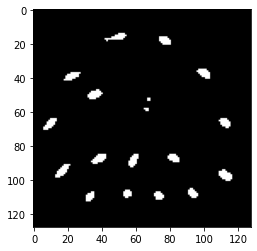

In [36]:
y_pred = model_focal_loss.predict(test_ultrasound_data)
evaluate_model(y_pred)

# IOU LOSS

In [37]:
max_learning_rate = 0.01
min_learning_rate = 0.00001

model_iou = nvidia_unet(ultrasound_size[0], num_classes)
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
filename='/content/drive/MyDrive/3DUnetSavedModels/model_iou.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)
model_iou.compile(optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss=jacard_coef_loss, 
               metrics=["accuracy", 
                        dice_coeff, 
                        tf.keras.metrics.Precision(), 
                        tf.keras.metrics.Recall(), 
                        iou_coef])
print("Learning rate decay = {}".format(learning_rate_decay))



Number of layers:       7
Filters in layers down: [ 8 14 20 26 32 38 44]
Filters in layers up:   [38 32 26 20 14  8  2]
Learning rate decay = 4.995e-05


In [38]:
training_time_start = datetime.datetime.now()

training_log_iou = model_iou.fit_generator(training_generator,
                                   validation_data=val_generator,
                                   epochs=num_epochs,
                                   verbose=1, callbacks=[callback,history_logger])


timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

saved_models_folder = '/content/drive/MyDrive/3DUnetSavedModels'
model_file_name = "model_iou_" + timestamp + ".h5"
weights_file_path = os.path.join(saved_models_folder, model_file_name)

model_iou.save(weights_file_path)
print("Unet Model saved to: {}".format(weights_file_path))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
13/13 [==============================] - 29s 2s/step - loss: 0.5990 - accuracy: 0.8248 - dice_coeff: 0.8436 - precision_5: 0.8248 - recall_5: 0.8248 - iou_coef: 0.4010 - val_loss: 0.6794 - val_accuracy: 0.6349 - val_dice_coeff: 0.6374 - val_precision_5: 0.6349 - val_recall_5: 0.6349 - val_iou_coef: 0.3206
Epoch 2/200
13/13 [==============================] - 23s 2s/step - loss: 0.5038 - accuracy: 0.9929 - dice_coeff: 0.9929 - precision_5: 0.9929 - recall_5: 0.9929 - iou_coef: 0.4962 - val_loss: 0.5048 - val_accuracy: 0.9905 - val_dice_coeff: 0.9905 - val_precision_5: 0.9905 - val_recall_5: 0.9905 - val_iou_coef: 0.4952
Epoch 3/200
13/13 [==============================] - 23s 2s/step - loss: 0.5036 - accuracy: 0.9928 - dice_coeff: 0.9928 - precision_5: 0.9928 - recall_5: 0.9928 - iou_coef: 0.4964 - val_loss: 0.5043 - val_accuracy: 0.9914 - val_dice_coeff: 0.9914 - val_precision_5: 0.9914 - val_recall_5: 0.9914 - val_iou_coef: 0.4957
Epoch 4/200
13/13 [========================

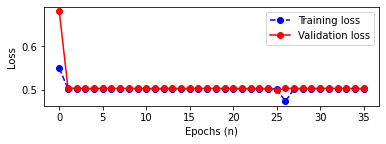

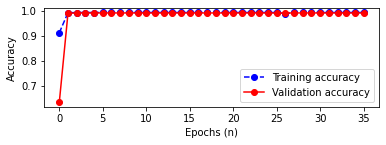

(128, 128, 128, 1)
(128, 128, 128, 1)
[0.0000000e+00 1.1755535e-38 1.1757239e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(128, 128, 128, 2)
[0.0000000e+00 1.1805687e-38 1.1837525e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(128, 128, 128, 2)
[0. 1.]


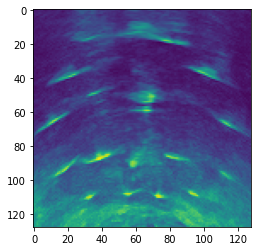

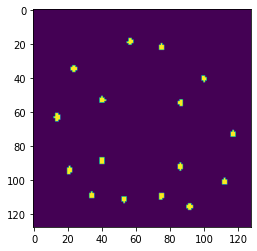

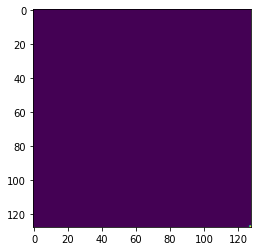

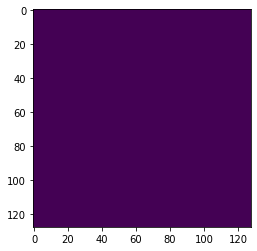

In [39]:
visualize_model(model_iou, training_log_iou)

0.012380774
(15, 128, 128, 128)
(15, 128, 128, 128)
True positive:  0.0
False positive:  2169.0
True negative:  31252496
False negative:  202615.0
True positive rate (recall):  0.0
False positive rate:  6.9397640320253e-05
Positive predictive value 0.0
Precision:  0.0
True negative rate:  0.9999306023596798
F1:  0.0
F2:  0.0
ROC-AUC:  0.4999653011798399
MCC:  -0.0006685940967947022
64
(128, 128, 128)
[0. 1.]


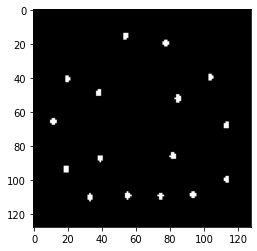

(128, 128, 128)
[0. 1.]


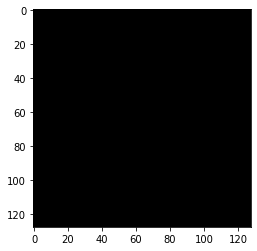

In [40]:
y_pred = model_iou.predict(test_ultrasound_data)
evaluate_model(y_pred)

# WEIGHTED CATEGORICAL CROSS ENTROPY

In [41]:
max_learning_rate = 0.01
min_learning_rate = 0.00001

model_wcce = nvidia_unet(ultrasound_size[0], num_classes)
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
filename='/content/drive/MyDrive/3DUnetSavedModels/model_wcce.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)
model_wcce.compile(optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss=weighted_categorical_crossentropy([0.0068, 1.0000]), 
               metrics=["accuracy", 
                        dice_coeff, 
                        tf.keras.metrics.Precision(), 
                        tf.keras.metrics.Recall(), 
                        iou_coef])
print("Learning rate decay = {}".format(learning_rate_decay))



Number of layers:       7
Filters in layers down: [ 8 14 20 26 32 38 44]
Filters in layers up:   [38 32 26 20 14  8  2]
Learning rate decay = 4.995e-05


In [42]:
training_time_start = datetime.datetime.now()

training_log_wcce = model_wcce.fit_generator(training_generator,
                                   validation_data=val_generator,
                                   epochs=num_epochs,
                                   verbose=1, callbacks=[callback,history_logger])


timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

saved_models_folder = '/content/drive/MyDrive/3DUnetSavedModels'
model_file_name = "model_wcce_" + timestamp + ".h5"
weights_file_path = os.path.join(saved_models_folder, model_file_name)

model_wcce.save(weights_file_path)
print("Unet Model saved to: {}".format(weights_file_path))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
13/13 [==============================] - 29s 2s/step - loss: 0.0132 - accuracy: 0.4649 - dice_coeff: 0.5593 - precision_6: 0.4649 - recall_6: 0.4649 - iou_coef: 0.2334 - val_loss: 0.0172 - val_accuracy: 0.5935 - val_dice_coeff: 0.6381 - val_precision_6: 0.5935 - val_recall_6: 0.5935 - val_iou_coef: 0.2780
Epoch 2/200
13/13 [==============================] - 24s 2s/step - loss: 0.0070 - accuracy: 0.6156 - dice_coeff: 0.7351 - precision_6: 0.6156 - recall_6: 0.6156 - iou_coef: 0.3000 - val_loss: 0.0067 - val_accuracy: 0.8608 - val_dice_coeff: 0.8854 - val_precision_6: 0.8608 - val_recall_6: 0.8608 - val_iou_coef: 0.4087
Epoch 3/200
13/13 [==============================] - 24s 2s/step - loss: 0.0048 - accuracy: 0.8717 - dice_coeff: 0.8840 - precision_6: 0.8717 - recall_6: 0.8717 - iou_coef: 0.4002 - val_loss: 0.0055 - val_accuracy: 0.8091 - val_dice_coeff: 0.8323 - val_precision_6: 0.8091 - val_recall_6: 0.8091 - val_iou_coef: 0.3889
Epoch 4/200
13/13 [========================

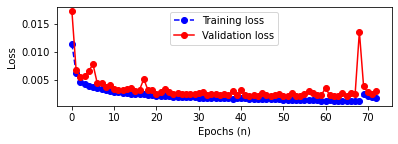

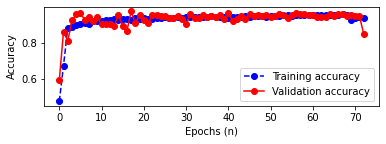

(128, 128, 128, 1)
(128, 128, 128, 1)
[3.2290321e-18 3.3725659e-18 3.4797553e-18 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(128, 128, 128, 2)
[3.5994337e-16 3.7199305e-16 3.8518450e-16 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(128, 128, 128, 2)
[0. 1.]


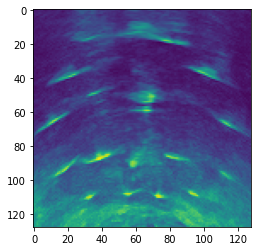

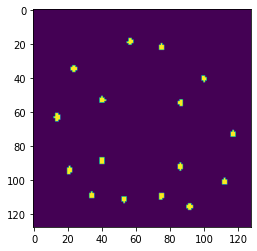

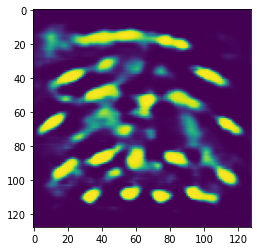

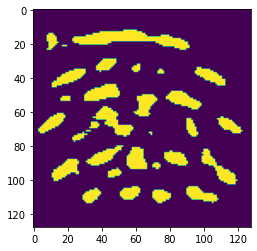

In [43]:
visualize_model(model_wcce, training_log_wcce)

0.39646792
(15, 128, 128, 128)
(15, 128, 128, 128)
True positive:  199071.0
False positive:  4579821.0
True negative:  26674844
False negative:  3544.0
True positive rate (recall):  0.9825086987636651
False positive rate:  0.14653239764367976
Positive predictive value 0.04165630861714389
Precision:  0.04165630861714389
True negative rate:  0.8534676023563202
F1:  0.07992400693203884
F2:  0.054323219101330866
ROC-AUC:  0.9179881505599927
MCC:  0.18631326941136667
64
(128, 128, 128)
[0. 1.]


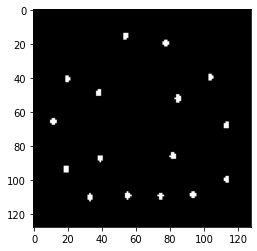

(128, 128, 128)
[0. 1.]


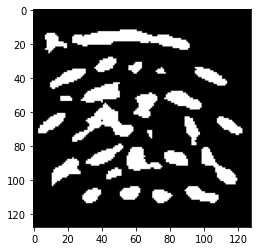

In [44]:
y_pred = model_wcce.predict(test_ultrasound_data)
evaluate_model(y_pred)

# WCCE - DICE

In [45]:
max_learning_rate = 0.01
min_learning_rate = 0.00001

model_weighted_bce_dice_loss = nvidia_unet(ultrasound_size[0], num_classes)
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
filename='/content/drive/MyDrive/3DUnetSavedModels/model_weighted_bce_dice_loss.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)
model_weighted_bce_dice_loss.compile(optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss=weighted_bce_dice_loss, metrics=["accuracy", 
                                                      dice_coeff, 
                                                      tf.keras.metrics.Precision(), 
                                                      tf.keras.metrics.Recall(), 
                                                      iou_coef])

print("Learning rate decay = {}".format(learning_rate_decay))

Number of layers:       7
Filters in layers down: [ 8 14 20 26 32 38 44]
Filters in layers up:   [38 32 26 20 14  8  2]
Learning rate decay = 4.995e-05


In [46]:
training_time_start = datetime.datetime.now()

training_log_weighted_bce_dice_loss = model_weighted_bce_dice_loss.fit_generator(training_generator,
                                   validation_data=val_generator,
                                   epochs=num_epochs,
                                   verbose=1, callbacks=[callback,history_logger])

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

saved_models_folder = '/content/drive/MyDrive/3DUnetSavedModels'
model_file_name = "model_weighted_bce_dice_loss_" + timestamp + ".h5"
weights_file_path = os.path.join(saved_models_folder, model_file_name)

model_weighted_bce_dice_loss.save(weights_file_path)
print("Unet Model saved to: {}".format(weights_file_path))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
13/13 [==============================] - 29s 2s/step - loss: 0.1673 - accuracy: 0.8340 - dice_coeff: 0.8558 - precision_7: 0.8340 - recall_7: 0.8340 - iou_coef: 0.3984 - val_loss: 0.3163 - val_accuracy: 0.6869 - val_dice_coeff: 0.7115 - val_precision_7: 0.6869 - val_recall_7: 0.6869 - val_iou_coef: 0.3417
Epoch 2/200
13/13 [==============================] - 24s 2s/step - loss: 0.0453 - accuracy: 0.9934 - dice_coeff: 0.9917 - precision_7: 0.9934 - recall_7: 0.9934 - iou_coef: 0.4857 - val_loss: 0.0508 - val_accuracy: 0.9916 - val_dice_coeff: 0.9885 - val_precision_7: 0.9916 - val_recall_7: 0.9916 - val_iou_coef: 0.4776
Epoch 3/200
13/13 [==============================] - 24s 2s/step - loss: 0.0387 - accuracy: 0.9934 - dice_coeff: 0.9879 - precision_7: 0.9934 - recall_7: 0.9934 - iou_coef: 0.4712 - val_loss: 0.0443 - val_accuracy: 0.9916 - val_dice_coeff: 0.9891 - val_precision_7: 0.9916 - val_recall_7: 0.9916 - val_iou_coef: 0.4774
Epoch 4/200
13/13 [========================

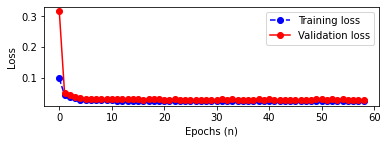

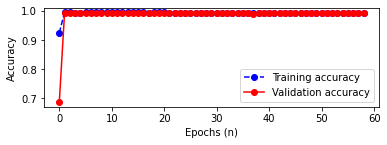

(128, 128, 128, 1)
(128, 128, 128, 1)
[4.0447726e-04 4.0612841e-04 4.0704021e-04 ... 9.9959296e-01 9.9959391e-01
 9.9959558e-01]
(128, 128, 128, 2)
[0.00122299 0.0012367  0.00124981 ... 0.9987502  0.9987633  0.998777  ]
(128, 128, 128, 2)
[0. 1.]


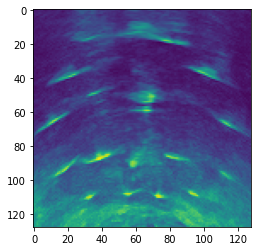

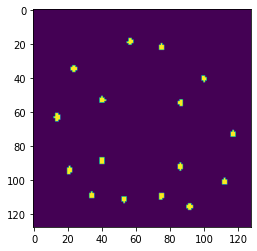

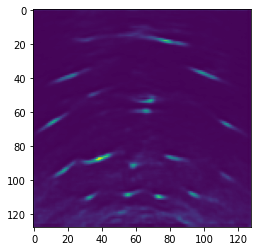

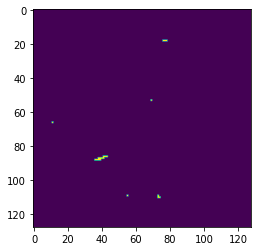

In [47]:
visualize_model(model_weighted_bce_dice_loss, training_log_weighted_bce_dice_loss)

0.17176431
(15, 128, 128, 128)
(15, 128, 128, 128)
True positive:  73993.0
False positive:  260557.0
True negative:  30994108
False negative:  128622.0
True positive rate (recall):  0.3651901389334452
False positive rate:  0.008336579515409939
Positive predictive value 0.22117172321028247
Precision:  0.22117172321028247
True negative rate:  0.9916634204845901
F1:  0.2754944942429235
F2:  0.31597984370329246
ROC-AUC:  0.6784267797090177
MCC:  0.2783004409347824
64
(128, 128, 128)
[0. 1.]


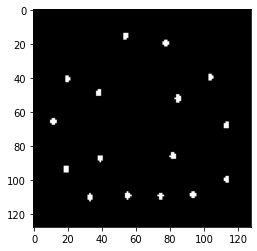

(128, 128, 128)
[0. 1.]


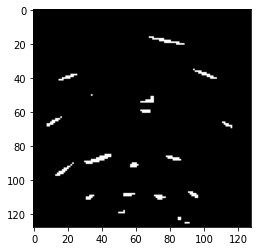

In [48]:
y_pred = model_weighted_bce_dice_loss.predict(test_ultrasound_data)
evaluate_model(y_pred)

# WCCE - FOCAL

In [49]:
max_learning_rate = 0.01
min_learning_rate = 0.00001

model_wcce_focal = nvidia_unet(ultrasound_size[0], num_classes)
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
filename='/content/drive/MyDrive/3DUnetSavedModels/model_wcce_focal.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)
model_wcce_focal.compile(optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss=wcce_focal, metrics=["accuracy", 
                                          dice_coeff, 
                                          tf.keras.metrics.Precision(), 
                                          tf.keras.metrics.Recall(), 
                                          iou_coef])

print("Learning rate decay = {}".format(learning_rate_decay))



Number of layers:       7
Filters in layers down: [ 8 14 20 26 32 38 44]
Filters in layers up:   [38 32 26 20 14  8  2]
Learning rate decay = 4.995e-05


In [50]:
training_time_start = datetime.datetime.now()

training_log_wcce_focal = model_wcce_focal.fit_generator(training_generator,
                                   validation_data=val_generator,
                                   epochs=num_epochs,
                                   verbose=1, callbacks=[callback,history_logger])

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

saved_models_folder = '/content/drive/MyDrive/3DUnetSavedModels'
model_file_name = "model_wcce_focal_" + timestamp + ".h5"
weights_file_path = os.path.join(saved_models_folder, model_file_name)

model_wcce_focal.save(weights_file_path)
print("Unet Model saved to: {}".format(weights_file_path))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
13/13 [==============================] - 30s 2s/step - loss: 0.1502 - accuracy: 0.7847 - dice_coeff: 0.8323 - precision_8: 0.7847 - recall_8: 0.7847 - iou_coef: 0.3638 - val_loss: 0.0787 - val_accuracy: 0.9904 - val_dice_coeff: 0.9781 - val_precision_8: 0.9904 - val_recall_8: 0.9904 - val_iou_coef: 0.4620
Epoch 2/200
13/13 [==============================] - 24s 2s/step - loss: 0.0606 - accuracy: 0.9905 - dice_coeff: 0.9863 - precision_8: 0.9905 - recall_8: 0.9905 - iou_coef: 0.4758 - val_loss: 0.0879 - val_accuracy: 0.9582 - val_dice_coeff: 0.9388 - val_precision_8: 0.9582 - val_recall_8: 0.9582 - val_iou_coef: 0.4186
Epoch 3/200
13/13 [==============================] - 24s 2s/step - loss: 0.0435 - accuracy: 0.9849 - dice_coeff: 0.9853 - precision_8: 0.9849 - recall_8: 0.9849 - iou_coef: 0.4842 - val_loss: 0.0430 - val_accuracy: 0.9916 - val_dice_coeff: 0.9899 - val_precision_8: 0.9916 - val_recall_8: 0.9916 - val_iou_coef: 0.4880
Epoch 4/200
13/13 [========================

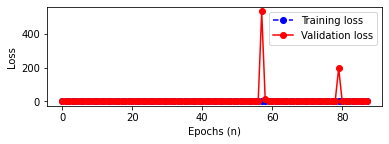

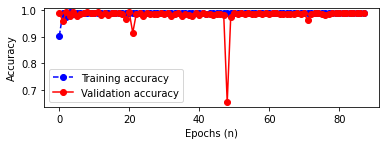

(128, 128, 128, 1)
(128, 128, 128, 1)
[7.3263656e-08 7.8324312e-08 7.8754844e-08 ... 9.9999964e-01 9.9999976e-01
 9.9999988e-01]
(128, 128, 128, 2)
[1.8656519e-07 1.8874671e-07 2.0912350e-07 ... 9.9999952e-01 9.9999964e-01
 9.9999976e-01]
(128, 128, 128, 2)
[0. 1.]


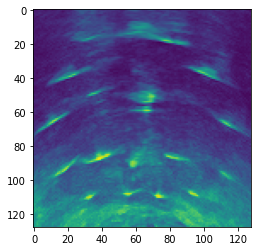

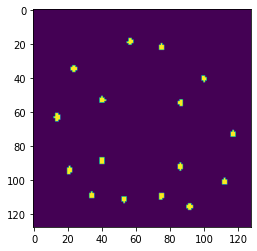

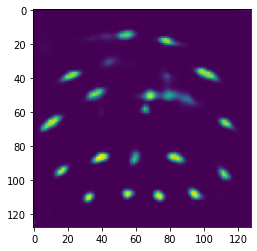

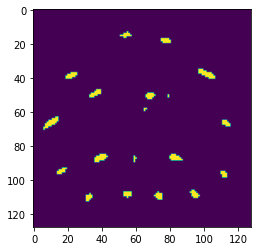

In [51]:
visualize_model(model_wcce_focal, training_log_wcce_focal)

0.25088897
(15, 128, 128, 128)
(15, 128, 128, 128)
True positive:  148936.0
False positive:  480314.0
True negative:  30774351
False negative:  53679.0
True positive rate (recall):  0.7350689731757274
False positive rate:  0.015367753901697555
Positive predictive value 0.2366881207787048
Precision:  0.2366881207787048
True negative rate:  0.9846322460983025
F1:  0.35807733225944116
F2:  0.37706557431004056
ROC-AUC:  0.8598506096370149
MCC:  0.41120743735579385
64
(128, 128, 128)
[0. 1.]


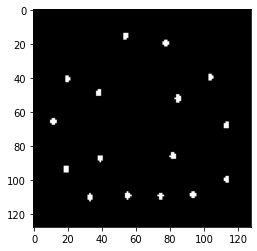

(128, 128, 128)
[0. 1.]


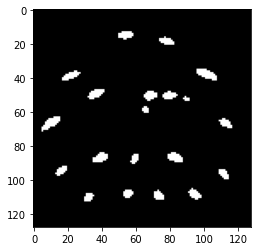

In [52]:
y_pred = model_wcce_focal.predict(test_ultrasound_data)
evaluate_model(y_pred)

# BINARY CROSS ENTROPY

In [59]:
max_learning_rate = 0.01
min_learning_rate = 0.00001

model_bce = nvidia_unet(ultrasound_size[0], num_classes)
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
filename='/content/drive/MyDrive/3DUnetSavedModels/model_bce.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)
model_bce.compile(optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss="binary_crossentropy", metrics=["accuracy", 
                                                      dice_coeff, 
                                                      tf.keras.metrics.Precision(), 
                                                      tf.keras.metrics.Recall(), 
                                                      iou_coef])

print("Learning rate decay = {}".format(learning_rate_decay))


Number of layers:       7
Filters in layers down: [ 8 14 20 26 32 38 44]
Filters in layers up:   [38 32 26 20 14  8  2]
Learning rate decay = 4.995e-05


In [60]:
training_time_start = datetime.datetime.now()

training_log_bce = model_bce.fit_generator(training_generator,
                                   validation_data=val_generator,
                                   epochs=num_epochs,
                                   verbose=1, callbacks=[callback,history_logger])

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

saved_models_folder = '/content/drive/MyDrive/3DUnetSavedModels'
model_file_name = "model_bce_" + timestamp + ".h5"
weights_file_path = os.path.join(saved_models_folder, model_file_name)

model_bce.save(weights_file_path)
print("Unet Model saved to: {}".format(weights_file_path))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
13/13 [==============================] - 34s 2s/step - loss: 0.5643 - accuracy: 0.7349 - dice_coeff: 0.7943 - precision_12: 0.7349 - recall_12: 0.7349 - iou_coef: 0.3568 - val_loss: 4.5672 - val_accuracy: 0.1838 - val_dice_coeff: 0.1922 - val_precision_12: 0.1838 - val_recall_12: 0.1838 - val_iou_coef: 0.0933
Epoch 2/200
13/13 [==============================] - 23s 2s/step - loss: 0.0706 - accuracy: 0.9934 - dice_coeff: 0.9934 - precision_12: 0.9934 - recall_12: 0.9934 - iou_coef: 0.4955 - val_loss: 0.4952 - val_accuracy: 0.7404 - val_dice_coeff: 0.7928 - val_precision_12: 0.7404 - val_recall_12: 0.7404 - val_iou_coef: 0.3674
Epoch 3/200
13/13 [==============================] - 24s 2s/step - loss: 0.0458 - accuracy: 0.9936 - dice_coeff: 0.9936 - precision_12: 0.9936 - recall_12: 0.9936 - iou_coef: 0.4967 - val_loss: 0.0523 - val_accuracy: 0.9916 - val_dice_coeff: 0.9916 - val_precision_12: 0.9916 - val_recall_12: 0.9916 - val_iou_coef: 0.4958
Epoch 4/200
13/13 [============

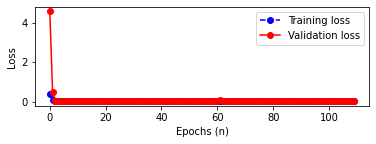

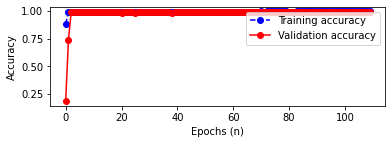

(128, 128, 128, 1)
(128, 128, 128, 1)
[0.0000000e+00 1.1788317e-38 1.1820018e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(128, 128, 128, 2)
[0.0000000e+00 1.1820018e-38 1.2780485e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(128, 128, 128, 2)
[0. 1.]


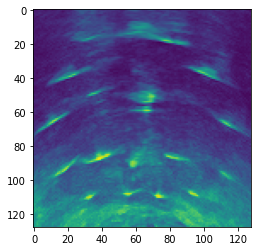

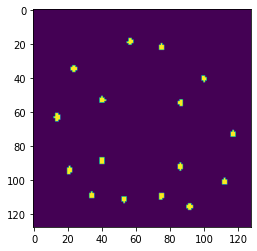

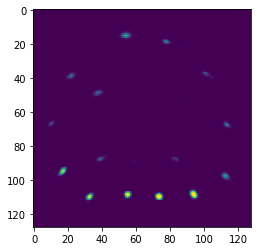

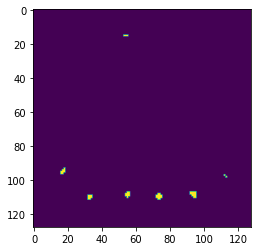

In [61]:
visualize_model(model_bce, training_log_bce)

0.3024376
(15, 128, 128, 128)
(15, 128, 128, 128)
True positive:  56158.0
False positive:  53421.0
True negative:  31201244
False negative:  146457.0
True positive rate (recall):  0.27716605384596404
False positive rate:  0.0017092168481089142
Positive predictive value 0.5124887067777585
Precision:  0.5124887067777585
True negative rate:  0.9982907831518911
F1:  0.35976348040000766
F2:  0.7796668527049128
ROC-AUC:  0.6377284184989276
MCC:  0.37400745857596895
64
(128, 128, 128)
[0. 1.]


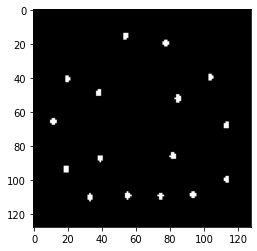

(128, 128, 128)
[0. 1.]


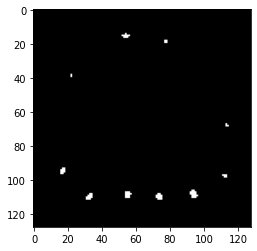

In [89]:
y_pred = model_bce.predict(test_ultrasound_data)
evaluate_model(y_pred)

#CCE

In [63]:
max_learning_rate = 0.01
min_learning_rate = 0.00001

model_cce = nvidia_unet(ultrasound_size[0], num_classes)
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
filename='/content/drive/MyDrive/3DUnetSavedModels/model_cce.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)
model_cce.compile(optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss="categorical_crossentropy", metrics=["accuracy", 
                                                      dice_coeff, 
                                                      tf.keras.metrics.Precision(), 
                                                      tf.keras.metrics.Recall(), 
                                                      iou_coef])

print("Learning rate decay = {}".format(learning_rate_decay))

Number of layers:       7
Filters in layers down: [ 8 14 20 26 32 38 44]
Filters in layers up:   [38 32 26 20 14  8  2]
Learning rate decay = 4.995e-05


In [64]:
training_time_start = datetime.datetime.now()

training_log_model_cce = model_cce.fit_generator(training_generator,
                                   validation_data=val_generator,
                                   epochs=num_epochs,
                                   verbose=1, callbacks=[callback,history_logger])

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

saved_models_folder = '/content/drive/MyDrive/3DUnetSavedModels'
model_file_name = "model_cce_" + timestamp + ".h5"
weights_file_path = os.path.join(saved_models_folder, model_file_name)

model_cce.save(weights_file_path)
print("Unet Model saved to: {}".format(weights_file_path))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
13/13 [==============================] - 28s 2s/step - loss: 0.6160 - accuracy: 0.7504 - dice_coeff: 0.7965 - precision_13: 0.7504 - recall_13: 0.7504 - iou_coef: 0.3524 - val_loss: 0.1384 - val_accuracy: 0.9807 - val_dice_coeff: 0.9748 - val_precision_13: 0.9807 - val_recall_13: 0.9807 - val_iou_coef: 0.4676
Epoch 2/200
13/13 [==============================] - 23s 2s/step - loss: 0.0618 - accuracy: 0.9935 - dice_coeff: 0.9925 - precision_13: 0.9935 - recall_13: 0.9935 - iou_coef: 0.4898 - val_loss: 0.1177 - val_accuracy: 0.9903 - val_dice_coeff: 0.9800 - val_precision_13: 0.9903 - val_recall_13: 0.9903 - val_iou_coef: 0.4620
Epoch 3/200
13/13 [==============================] - 23s 2s/step - loss: 0.0586 - accuracy: 0.9935 - dice_coeff: 0.9933 - precision_13: 0.9935 - recall_13: 0.9935 - iou_coef: 0.4950 - val_loss: 0.0701 - val_accuracy: 0.9915 - val_dice_coeff: 0.9902 - val_precision_13: 0.9915 - val_recall_13: 0.9915 - val_iou_coef: 0.4870
Epoch 4/200
13/13 [============

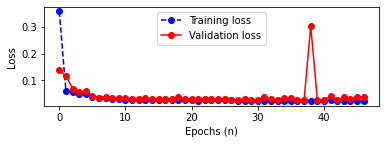

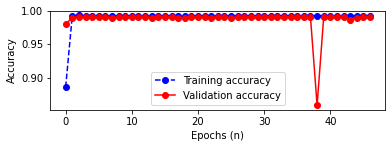

(128, 128, 128, 1)
(128, 128, 128, 1)
[3.8263485e-12 6.0547314e-12 7.0257281e-12 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(128, 128, 128, 2)
[2.1415055e-11 2.2266732e-11 2.3549239e-11 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(128, 128, 128, 2)
[0. 1.]


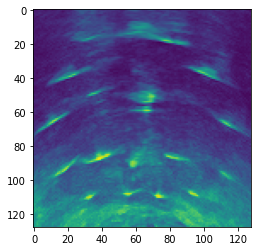

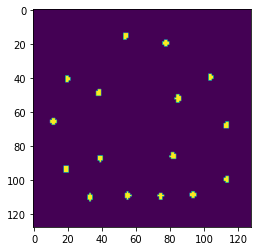

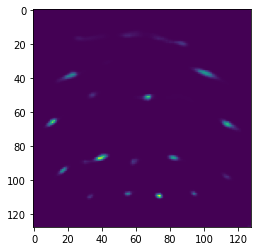

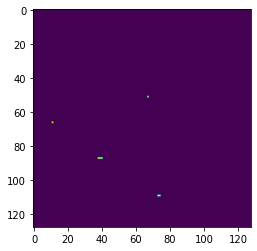

In [79]:
visualize_model(model_cce, training_log_model_cce)

0.16619606
(15, 128, 128, 128)
(15, 128, 128, 128)
True positive:  33809.0
False positive:  43989.0
True negative:  31210676
False negative:  168806.0
True positive rate (recall):  0.16686326283838807
False positive rate:  0.0014074378976706356
Positive predictive value 0.4345741535772128
Precision:  0.4345741535772128
True negative rate:  0.9985925621023294
F1:  0.24113717980264823
F2:  0.4903237595790719
ROC-AUC:  0.5827279124703587
MCC:  0.26648218526567874
64
(128, 128, 128)
[0. 1.]


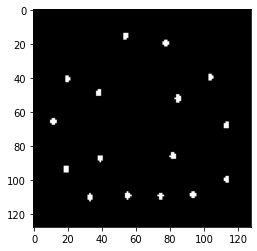

(128, 128, 128)
[0. 1.]


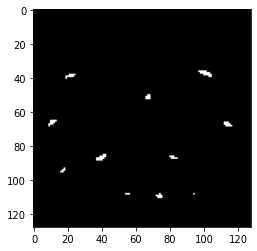

In [90]:
y_pred = model_cce.predict(test_ultrasound_data)
evaluate_model(y_pred)

# WEIGHTED CATEGORICAL CROSS ENTROPY ORIGINAL WEIGHTS

In [67]:
max_learning_rate = 0.01
min_learning_rate = 0.00001

model_wcce_og = nvidia_unet(ultrasound_size[0], num_classes)
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
filename='/content/drive/MyDrive/3DUnetSavedModels/model_wcce_og.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)
model_wcce_og.compile(optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss=weighted_categorical_crossentropy([0.05, 0.95]), 
               metrics=["accuracy", 
                        dice_coeff, 
                        tf.keras.metrics.Precision(), 
                        tf.keras.metrics.Recall(), 
                        iou_coef])
print("Learning rate decay = {}".format(learning_rate_decay))



Number of layers:       7
Filters in layers down: [ 8 14 20 26 32 38 44]
Filters in layers up:   [38 32 26 20 14  8  2]
Learning rate decay = 4.995e-05


In [68]:
training_time_start = datetime.datetime.now()

training_log_wcce_og = model_wcce_og.fit_generator(training_generator,
                                   validation_data=val_generator,
                                   epochs=num_epochs,
                                   verbose=1, callbacks=[callback,history_logger])


timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

saved_models_folder = '/content/drive/MyDrive/3DUnetSavedModels'
model_file_name = "model_wcce_og_" + timestamp + ".h5"
weights_file_path = os.path.join(saved_models_folder, model_file_name)

model_wcce_og.save(weights_file_path)
print("Unet Model saved to: {}".format(weights_file_path))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
13/13 [==============================] - 29s 2s/step - loss: 0.0466 - accuracy: 0.7108 - dice_coeff: 0.7475 - precision_14: 0.7108 - recall_14: 0.7108 - iou_coef: 0.3233 - val_loss: 0.3932 - val_accuracy: 0.1540 - val_dice_coeff: 0.1634 - val_precision_14: 0.1540 - val_recall_14: 0.1540 - val_iou_coef: 0.0796
Epoch 2/200
13/13 [==============================] - 23s 2s/step - loss: 0.0221 - accuracy: 0.9803 - dice_coeff: 0.9642 - precision_14: 0.9803 - recall_14: 0.9803 - iou_coef: 0.4413 - val_loss: 0.0277 - val_accuracy: 0.9855 - val_dice_coeff: 0.9702 - val_precision_14: 0.9855 - val_recall_14: 0.9855 - val_iou_coef: 0.4543
Epoch 3/200
13/13 [==============================] - 23s 2s/step - loss: 0.0165 - accuracy: 0.9759 - dice_coeff: 0.9687 - precision_14: 0.9759 - recall_14: 0.9759 - iou_coef: 0.4544 - val_loss: 0.0237 - val_accuracy: 0.9888 - val_dice_coeff: 0.9890 - val_precision_14: 0.9888 - val_recall_14: 0.9888 - val_iou_coef: 0.5017
Epoch 4/200
13/13 [============

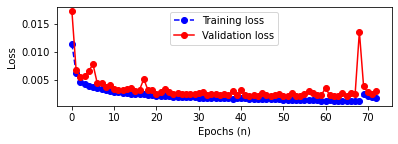

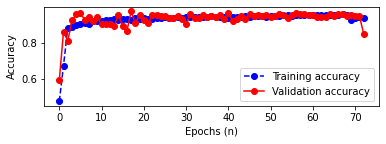

(128, 128, 128, 1)
(128, 128, 128, 1)
[0.0000000e+00 1.1818484e-38 1.1834365e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(128, 128, 128, 2)
[0.0000000e+00 1.1818484e-38 1.2190760e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(128, 128, 128, 2)
[0. 1.]


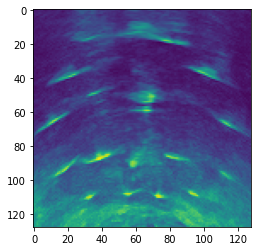

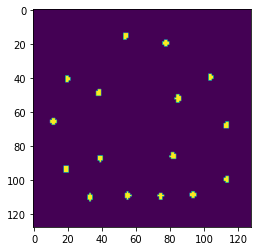

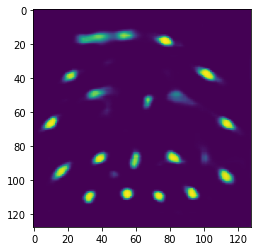

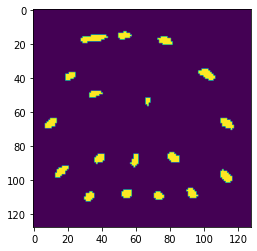

In [78]:
visualize_model(model_wcce_og, training_log_wcce)

0.39646792
(15, 128, 128, 128)
(15, 128, 128, 128)
True positive:  199071.0
False positive:  4579821.0
True negative:  26674844
False negative:  3544.0
True positive rate (recall):  0.9825086987636651
False positive rate:  0.14653239764367976
Positive predictive value 0.04165630861714389
Precision:  0.04165630861714389
True negative rate:  0.8534676023563202
F1:  0.07992400693203884
F2:  0.054323219101330866
ROC-AUC:  0.9179881505599927
MCC:  0.18631326941136667
64
(128, 128, 128)
[0. 1.]


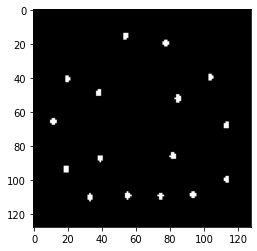

(128, 128, 128)
[0. 1.]


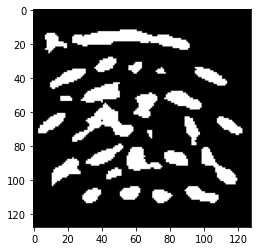

In [91]:
y_pred = model_wcce.predict(test_ultrasound_data)
evaluate_model(y_pred)

# ZIP AND DOWNLOAD

In [ ]:
from google.colab import files
!zip -r /content/saved_models.zip /content/saved_models
files.download("/content/saved_models.zip")